# Molecular Dynamics using Lennard-Jones Potential

In this simulation, we visualize the dynamics of an 2D monoatomic molecular network (comparable to a cristal) under a Lennard-Jones Potential.

## Assumptions 

* The molecules are represented by a circles of same radius and have same mass
* The velocities of the molecules are ramdomly distributed
* We consider a periodic boundary conditions 
* We only consider forces caused by the Lennard-Jones potential

## Algorithm
The idea behind algorithm is quite simple.

* We create the molecular network and attribute an random velocities to each particule.
* We compute the forces applied to each particule under periodic boundary conditions.
* We compute the evolution of the network at each time step using verlet algorithm.
* We stock all the positions and velocities in order to do an simulation 
* For verification purposes, we determine the kinetic and potential energy and verify the energy conservation law (another cool verification is to see if the equilibrium velocity distribution obey to the maxwell-boltzmann distribution)   

## The Lennard-Jones potential

The Lennard-Jones (LJ) potential between two particles is given by: 

$$U_{LJ}(\vec r) = 4 \epsilon \left[ \left( \frac{\sigma}{r}\right)^{12} - \left( \frac{\sigma}{r}\right)^{6} \right],$$
where $r = |\vec r|$ is the distance between the two particles. We will use reduced units $\epsilon \to 1$, $\sigma \to 1$ , i.e work in units of $\epsilon$ and $\sigma$. Since $U_{LJ}$ rapidly approaches $0$ as $r$ increases, we introduce a cutoff $r_c$ such that $U_{LJ}(r > r_c) = 0.$ For this simulation, we'll take $r_c = 2.5$ units of $\sigma$. 

In [53]:
# Defining constants and variable of the simulation

import numpy as np
import matplotlib.pyplot as plt
import random
import matplotlib.animation as animation              
import matplotlib.patches as patches
from itertools import product


N = 100   # number of atoms

# time constants 
duration = 10 
nsteps = 1500 # number of time steps
dt = duration/nsteps # time step

# length constants
rc = 2.5 #cutoff distance
L = int(N**0.5)  # Length of the box
rc = 2.5 #cutoff distance
v0 = 1.5 # initial velocity norm
gap = int(N**0.5)/L # distance between particles

# variables
positions = np.zeros((N,2))
velocities = np.zeros_like(positions)

#Other
atoms = [] # list which will contains all the patches


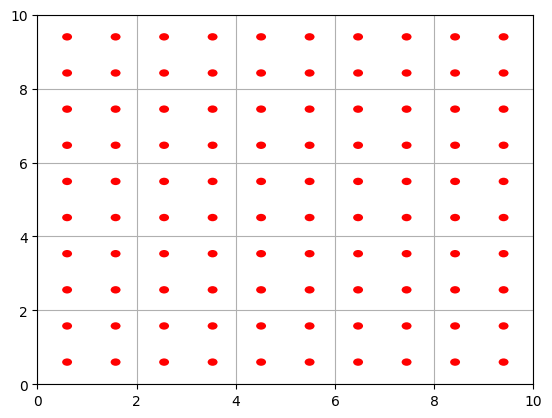

In [54]:
#initialisation

fig, ax = plt.subplots()

def init(positions,velocities,v0, L, N):
    
    x = np.linspace(gap/2 + 0.1 , L - gap/2 - 0.1, int(N**0.5 ))

    positions = np.array(list(product(x,x))[:N]) # fixing the initial positions of particules as a grid network

    for i in range(0,N):
        theta = random.uniform(0.0, 2*np.pi)
        velocities[i][:] = [v0*np.cos(theta),v0*np.sin(theta)] # choosing randomly the directions of velocities
    
    for i in range (N):
        atom = patches.Circle((positions[i,0],positions[i,1]),0.1,facecolor='red') # creating a patches for each particule
        ax.add_patch(atom)
        atoms.append(atom)

    return positions,velocities


positions,velocities = init(positions,velocities,v0, L, N)
ax.set_xlim(0,L )
ax.set_ylim(0, L )
ax.grid()


In [55]:

# Function for choosing the smallest distance between particules under periodic boundary conditions
def interact_closer_pict(x,L):
    x_abs = np.abs(x)
    if x_abs> L/2:
        return (x_abs - L)*np.sign(x)
    else:
        return x


# Force computation function 
def forces_computation(positions,N,L):
    forces = np.zeros_like(positions)
    for i in range (0,N-1):
        for j in range(i+1,N):
            dx = positions[i,0] - positions[j,0]
            dy = positions[i,1] - positions[j,1]
            dx = interact_closer_pict(dx,L)
            dy = interact_closer_pict(dy,L)

            if dx*dx + dy*dy > rc**2:
                force = 0
            else:
                r_inv =  1/np.sqrt(dx*dx + dy*dy)
                force = 24* r_inv**8 * (2*r_inv**6 -1)
            
            forces[i,0] += force*dx
            forces[i,1] += force*dy

            forces[j,0] += -force*dx
            forces[j,1] += -force*dy
    return forces

        

In [56]:
# evolution of particules at each time step (using verlet algorithm)
 
def step_evolution(positions,velocities,N,L,dt):
    dt2 = dt*dt
    
    forces = forces_computation(positions,N,L) 

    positions = positions + dt*velocities + 0.5*dt2*forces

    next_forces = forces_computation(positions,N,L)
    
    velocities = velocities + 0.5*dt*(forces+next_forces)

    for i in range (N):       # For assuring periodic boundaries 
        if positions[i,0] > L:
            positions[i,0] -= L
        if positions[i,0] < 0:
            positions[i,0] += L
        if positions[i,1] > L:
            positions[i,1] -= L
        if positions[i,1] < 0:
            positions[i,1] += L


    
    return positions,velocities

In [57]:
# simulation by time iterations and collecting all the data through the duration of the simulation

all_positions = np.zeros((nsteps,N,2)) # stock all the positions (computed at each time)  
all_velocities = np.zeros_like((all_positions)) # stock all velocities

for t in range (0,nsteps):
    all_positions[t] = positions #add to positions positions
    all_velocities[t] = velocities #add to velocities velocities
    positions, velocities = step_evolution(positions, velocities,N,L,dt) #step forward in time




In [81]:
# computing the total potential energy
potential_energy = np.zeros(nsteps)
for k in range (nsteps):
    for i in range(0,N-1):
        for j in range (i+1,N):
            dx = interact_closer_pict(all_positions[k,i,0] - all_positions[k,j,0],L)
            dy = interact_closer_pict(all_positions[k,i,1] - all_positions[k,j,1],L)
            if dx == 0 and dy == 0 :
                print(k,i,j)
                break
            r = (dx*dx + dy*dy)**0.5

            if r < rc:
                potential_energy[k] += 4*(1/r**12 - 1/r**6)


# computing the total potential energy
kinetic_energy = 0.5 * np.sum(np.linalg.norm(all_velocities, axis=2)**2,axis=1)



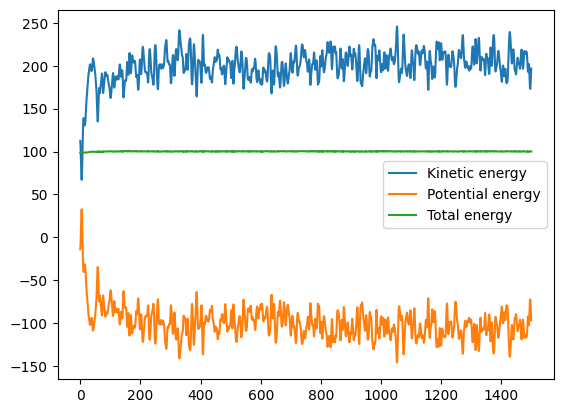

In [93]:
plt.plot(np.arange(nsteps), kinetic_energy, label = 'Kinetic energy')
plt.plot(np.arange(nsteps), potential_energy, label = 'Potential energy')
plt.plot(np.arange(nsteps), potential_energy+kinetic_energy, label = 'Total energy')
plt.legend()
plt.show()

[]

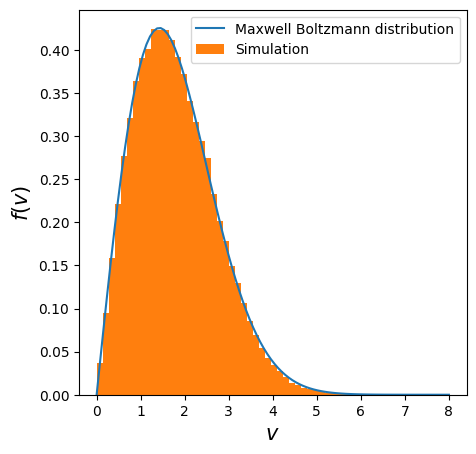

In [90]:

kT = np.mean(kinetic_energy[200:])/N # equipartition law

Maxwell_Boltzmann_dist = lambda v: (v/kT)*np.exp(-v**2/(2*kT))

v = np.linspace(0,8,100)

speeds = np.linalg.norm(all_velocities, axis=2)

plt.figure(figsize=(5,5))
plt.plot(v,Maxwell_Boltzmann_dist(v),label='Maxwell Boltzmann distribution')
plt.hist(speeds[200:].flatten(), bins=50, density=True, label='Simulation')
plt.xlabel('$v$', fontsize=15)
plt.ylabel('$f(v)$', fontsize=15)
plt.legend()
plt.plot()

In [58]:


def anim(t):
    for i in range(N):
        x,y = all_positions[t,i,0]%L , all_positions[t,i,1]%L
        atoms[i].center = x,y
        ax.set_xlim(0,L)
        ax.set_ylim(0,L)
        
        
    
interval = duration*1e3/nsteps
ani = animation.FuncAnimation(fig, anim, frames = int(nsteps), interval=interval, repeat=True)
ani.save('lennard_jones_simulation.gif', writer='pillow')


